# Fashion Sense

<a id = 'toc'></a>
## Table of Contents
1. [Introduction](#intro)
2. [Reading in the Data](#load_data)<br>

### [Part I: Before the Beginning](#partI)<br>

3. [Data Augmentation](#data_augmentation)<br>
    3.1 [Data Augmentation Functions](#data_aug_fn)<br>
    3.2 [Data Augmentation Step](#data_augmentation_step)<br>

### [Part II: Birthing](#partII)<br>

4. [Convolutional Neural Network](#cnn)<br>
    4.1 [Helper Functions Definitions](#defhelper)<br>
    4.2 [Training the model and Observing the Metrics](#training)<br>
    4.3 [Comparison of Different Models](#model_comparison)

### [Part III: Search for a Road Less Travelled](#partIII)<br>

5. [On hyperparameters and other Mundanities](#tuning_path)<br>
    5.1 [Modified LeNet Model](#mod_lenet)<br>
    5.2 [A Modified CNN Function](#modified_cnn)<br>
    5.3 [Training the Modified LeNet Model](#training_mod_lenet)<br>
    5.4 [Comparison of LeNet and Modified LeNet](#plotting_lenet_and_mod_lenet)

<a id='intro'></a>
## [1. Introduction](#toc)

Okay. I guess at some point, even our devices will be able to judge our fashion choices! What we'll be attempting to do in this notebook is to simply train a neural network to classify images of clothing. While at a cursory glance this seems like a fairly simple problem statement. Especially when we consider that we'll be using vanilla mnist fashion dataset (with data augmentation but still its a fairly common dataset). However the consequences are far-reaching. I can already envision a future when our "smart mirrors" will be able to recommend a matching pair of clothes from our wardrobes. And the first step to this is to enable our machines to correctly identify and classify clothing. 

<a id='load_data'></a>
## [2. Reading in the Data](#toc)

The first task is to import utf-8 encoded data, decompress it and store it in a numpy array of the correct dimensions. There are supposed to be 60000 examples in the training set and 10000 examples in the test set.

In [1]:
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [2]:
def load_data():
    """
    This function returns training and test features and labels
    Arguments: None
    Returns: training_images, training_labels, test_images, test_labels
    """
    import gzip
    with open("./Data/train-images-idx3-ubyte.gz", 'rb') as f:
        data = f.read()
        training_images = np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
        
    with open("./Data/train-labels-idx1-ubyte.gz", 'rb') as f:
        data = f.read()
        training_labels = np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
    
    with open("./Data/t10k-images-idx3-ubyte.gz", 'rb') as f:
        data = f.read()
        test_images = np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
    with open("./Data/t10k-labels-idx1-ubyte.gz", 'rb') as f:
        data = f.read()
        test_labels = np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()   
    
    return training_images[16:].reshape((-1,28,28)), np.squeeze(training_labels[8:]), test_images[16:].reshape((-1,28,28)), np.squeeze(test_labels[8:])

In [3]:
training_images, training_labels, test_images, test_labels = load_data()
label_mapping = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

I'll first validate the data that has been read to confirm that indeed the data is in the form that I expect it to be in (need to do this since the original data wasn't exactly divisible by 784 which led me to drop the first few pixel values and also dropped the first few values of labels as evident from the function I have written. This is just a sanity check to ensure that the dropped pixels and labels don't cause any shift in the pixel values that belong to a particular example)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
Number of unique pixel values in the training set:256
Number of unique pixel values in the test set:256
Number of unique labels in training set:10
Number of unique labels in test set:10


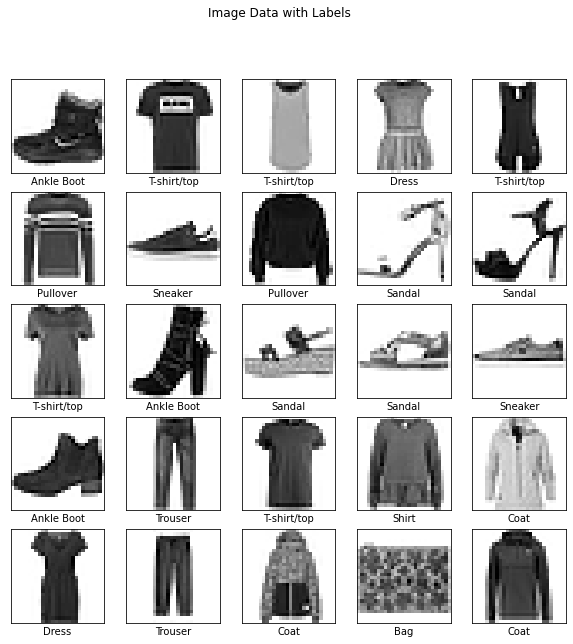

In [4]:
print(training_images.shape)
print(training_labels.shape)
print(test_images.shape)
print(test_labels.shape)

print(f'Number of unique pixel values in the training set:{len(np.unique(training_images.reshape((training_images.shape[0], -1))))}')
print(f'Number of unique pixel values in the test set:{len(np.unique(test_images.reshape((test_images.shape[0], -1))))}')
print(f'Number of unique labels in training set:{len(np.unique(training_labels))}\nNumber of unique labels in test set:{len(np.unique(test_labels))}')

plt.figure(figsize=(10,10))
plt.suptitle("Image Data with Labels")
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i], cmap=plt.cm.binary)
    plt.xlabel(label_mapping[training_labels[i]])

Man its great when things work! With the confirmation that the pictures and labels match up, we can move to the next step which is data augmentation.

<a id = "partI"></a>
# [Part I: Before the Beginning](#toc)
> Want some data? Make your own!

<a id="data_augmentation"></a>
## [3. Data Augmentation](#toc)

In this section we'll be using data augmentation techniques to add to the dataset. And boy this is going to make things tougher for our network!

<a id = 'data_aug_fn'></a>
### 3.1 [Data Augmentation Functions](#toc)

This brings us to deciding what augmentation techniques could be employed here. Right off the bat, I can think of:
1. Flipping (horizontal and vertical)
2. Random Cropping
3. Random Rotation
4. Histogram Equalisation
5. Introduction of Random Noise
6. Filtering (unsuitable since input size of image is really small)
7. Scaling techniques but I really want to avoid these!!

Lets get started with the function definitions.

In [5]:
def flipping(img, axis = "horizontal"):
    """
    Flip image about the axis chosen
    Arguments: Image and axis of rotation (since this is a 180 degree rotation about the chosen axis)
    Returns: Flipped image as per chosen axis
    """
    if axis == "horizontal":
        return cv.flip(img, 1)
    elif axis == "vertical":
        return cv.flip(img, 0)
    elif axis == "both":
        return cv.flip(img, -1)
    
def random_cropping(img, scale = 0.9):
    """
    Random crop of the image based on the scale chosen
    Arguments: Image and scale based on which cropping dimensions are chosen
    Returns: Cropped image as per chosen axis
    """
    height, width = int(img.shape[0] * scale), int(img.shape[1] * scale)
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    cropped = img[y:y+height, x:x+height]
    return cv.resize(cropped, (img.shape[1], img.shape[0]), interpolation=cv.INTER_AREA);

def random_rotation(img, rotation_point = None):
    """
    Random rotation of the image based on the rotation point chosen
    Arguments: Image and rotation point about which image will be rotated
    Returns: Rotated image as per chosen rotation point and randomly generated angle
    """
    (height, width) = img.shape
    
    if rotation_point is None:
        rotation_point = (width//2, height//2)
    
    angle = random.randint(5, 355)
    
    rotMat = cv.getRotationMatrix2D(rotation_point, angle, 1.0)
    dimensions = (width, height)
    return cv.warpAffine(img, rotMat,dimensions)

def histogram_equalisation(img):
    """
    Carries out histogram equalisation to better distribute pixel intensity values across the image
    Arguments: Image
    Returns: Histogram equalised output for image
    """
    return cv.equalizeHist(img)

def add_noise(img, noise="gauss"):
    """
    Adds a random noise component to the input image based on the type chosen
    Arguments: Image and noise type
                One thing to note that dark pixels correspond to 255 and light to 0.
    Returns: Noisy output
    """
    if noise == "gauss": 
        mean=0
        std=0.8
        gaussian_filter = np.random.normal(mean,std,img.shape)
        gaussian_filter = gaussian_filter.astype('uint8')
        img = cv.add(img,gaussian_filter)
    elif noise == "salt_pepper":
        prob = 0.05
        white = 0
        black = 255
        probs = np.random.random(img.shape)
        img[probs < (prob / 2)] = black
        img[probs > 1 - (prob / 2)] = white
    return img

def scaling(img, type = "linear_clipped"):
    """
    Scales Image as per option chosen
    Arguments: Image and option between 'linear_clipped','non_linear_log' and 'non_linear_exp'. 
                One thing to note is that dark pixels correspond to 255 and light to 0.
    Returns: Scaled output
    """
    if type == "linear_clipped":
        slope = random.uniform(1,3)
        return (slope*img.astype(int)).astype('uint8')
    elif type == "non_linear_log": # more useful as light pixels are made darker.
        return (46 * np.log(img.astype(int) + 1)).astype('uint8')
    elif type == "non_linear_exp": # Not useful since the light pixels (close to 0) are made even lighter
        temp = (np.exp(img.astype(int)) - 1)*255/(np.exp(255) - 1)
        return temp.astype('uint8')

We absolutely can't use filtering here since the input images are $28\times28$ which is a really small input size. If we use padding it will have a significant effect on the output since 1 is significant with respect to 28. Padding only really works well in case of dimensions that are significant. 

<a id = 'data_augmentation_step'></a>
### 3.2 [Data Augmentation Step](#toc)

Now all we need to do is to define a data augmentation function that will enable us to create new training data from existing data and labels.

In [6]:
def augment_data(training_images, training_labels):
    """
    
    """
    training_images_augmented = []
    training_labels_augmented = []
    axes = ["horizontal","vertical","both"]
    noise_types = ["gauss","salt_pepper"]
    scaling_option = ["linear_clipped","non_linear_log"]
    for i in range(training_images.shape[0]):
        training_images_augmented.append(training_images[i])
        training_labels_augmented.append(training_labels[i])
        
        flipping_choice = random.randint(0,2)
        training_images_augmented.append(flipping(training_images[i],axes[flipping_choice]))
        training_labels_augmented.append(training_labels[i])
        
        training_images_augmented.append(random_cropping(training_images[i]))
        training_labels_augmented.append(training_labels[i])
        
        training_images_augmented.append(random_rotation(training_images[i]))
        training_labels_augmented.append(training_labels[i])
        
        training_images_augmented.append(histogram_equalisation(training_images[i]))
        training_labels_augmented.append(training_labels[i])
        
        noise_choice = random.randint(0,1) #The rhyme here 😛
        training_images_augmented.append(add_noise(training_images[i], noise_types[noise_choice]))
        training_labels_augmented.append(training_labels[i])
        
        scaling_choice = random.randint(0,1)
        training_images_augmented.append(scaling(training_images[i], scaling_option[scaling_choice]))
        training_labels_augmented.append(training_labels[i])
        
    training_images_augmented = np.array(training_images_augmented)
    training_labels_augmented = np.array(training_labels_augmented)
    
    p = np.random.permutation(len(training_labels_augmented))
    training_images_augmented_shuffled = training_images_augmented[p]
    training_labels_augmented_shuffled = training_labels_augmented[p]
    
    return training_images_augmented_shuffled, training_labels_augmented_shuffled

We'll perform a small sanity check before proceeding to feed it to our convolutional neural network

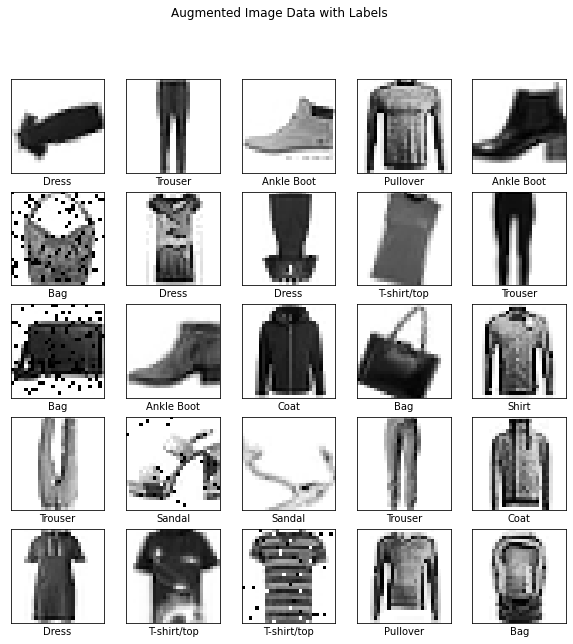

In [7]:
training_images_augmented, training_labels_augmented = augment_data(training_images, training_labels)

plt.figure(figsize=(10,10))
plt.suptitle("Augmented Image Data with Labels")
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images_augmented[i], cmap=plt.cm.binary)
    plt.xlabel(label_mapping[training_labels_augmented[i]])

We'll also define a function that will be damn useful in the next segment of this notebook.

In [8]:
def reshape_images(image_data):
    """
    Reshape Image data into a format that keras can process
    Arguments: Vector containing multiple images
    Returns: Vector with multiple images with increased number of dimensions
    """
    image_data = image_data.reshape(image_data.shape[0],
                                    image_data.shape[1],
                                    image_data.shape[2],
                                    1)
    return image_data

<a id = "partII"></a>
# [Part II: Birthing](#toc)

> Rise my glorious creation, rise....

<a id = "cnn"></a>
## 4. [Convolutional Neural Network](#toc)

We'll be implementing various well-known CNN architectures (with a few tweaks) since some of those applications seem pretty close to what we're attempting to do here

<a id = 'defhelper'></a>
### 4.1 [Helper Function Definitions](#toc)

In this section, we'll be looking to define certain functions that will help us to implement our CNN. Some standard CNN architectures namely LeNet and VGG with a few tweaks to suit the dataset are implemented.

In [35]:
def LeNet(training_images_augmented, training_labels_augmented, validation_images, validation_labels, kernel_size = 3, optimizer = "adam", loss = keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'], epochs = 5):
    """
    Implements a tweaked version of the LeNet neural network
    
    Arguments:-
    1) Training Image Data
    2) Training Labels
    3) Cross Validation Set Image Data
    4) Cross Validation Set Label Data
    5) Kernel Size of all Convolution layers
    6) Optimizer for learning rate
    7) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
    8) Metrics to judge model performance
    9) Number of epochs
    
    Returns:-
    Trained model implementing LeNet Neural Network with a few modifications (such as kernel size variation, activation function)
    """
    lenet_model = keras.models.Sequential([
                                            keras.layers.Conv2D(6, kernel_size=kernel_size, strides=1,  activation='relu', input_shape=training_images_augmented[0].shape, padding='same'), 
                                            keras.layers.MaxPool2D(),
                                            keras.layers.Conv2D(16, kernel_size=kernel_size, strides=1, activation='relu', padding='same'),
                                            keras.layers.MaxPool2D(),
                                            keras.layers.Flatten(),
                                            keras.layers.Dense(120, activation='relu'),
                                            keras.layers.Dense(84, activation='relu'),
                                            keras.layers.Dense(10, activation='softmax')
                                            ])

    lenet_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

    history = lenet_model.fit(training_images_augmented, training_labels_augmented, epochs=epochs, verbose = 1, validation_data=(validation_images, validation_labels))
    return lenet_model, history

def VGG(training_images_augmented, training_labels_augmented, validation_images, validation_labels, kernel_size = 3, optimizer = "adam", loss = keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'], epochs = 5):
    '''
    We need to go deeper
    Implements a version of the VGG neural network
    
    Arguments:-
    1) Training Image Data
    2) Training Labels
    3) Cross Validation Set Image Data
    4) Cross Validation Set Label Data
    5) Kernel Size of all Convolution layers
    6) Optimizer for learning rate
    7) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
    8) Metrics to judge model performance
    9) Number of epochs
    
    Returns:-
    Trained model implementing VGG Neural Network with a few modifications (such as kernel size variation, reduced number of layers and output of neural network has fewer classes than the original VGG)
    '''
    vgg_model = keras.models.Sequential([
                                        keras.layers.Conv2D(64, kernel_size = kernel_size, padding = 'same', activation = 'relu', input_shape = training_images_augmented[0].shape),
                                        keras.layers.Conv2D(64, kernel_size = kernel_size, padding = 'same', activation = 'relu'),
                                        keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'same'), # Layer 1
                                        keras.layers.Conv2D(128, kernel_size = kernel_size, padding = 'same', activation = 'relu'),
                                        keras.layers.Conv2D(128, kernel_size = kernel_size, padding = 'same', activation = 'relu'),
                                        keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'same'), #Layer 2
                                        keras.layers.Flatten(),
                                        keras.layers.Dense(4096, activation='relu'), #FC1
                                        keras.layers.Dense(4096, activation='relu'), #FC2
                                        keras.layers.Dense(10, activation='softmax') #softmax output layer
                                        ])
    vgg_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

    history = vgg_model.fit(training_images_augmented, training_labels_augmented, epochs=epochs, verbose = 1, validation_data=(validation_images, validation_labels))
    return vgg_model, history

def implement_cnn(training_images_augmented, validation_images, training_labels_augmented, validation_labels, cnn_model = "lenet", kernel_size = 3, optimizer = "adam", loss = keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'], epochs = 5):
    """
    Implements CNN based on choice of architecture
    Arguments:-
    1) Training Image Data
    2) Cross Validation Set Image Data
    3) Training Labels
    4) Cross Validation Set Label Data
    5) Choice of CNN architecture
    6) Kernel Size of all Convolution layers
    7) Optimizer for learning rate
    8) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
    9) Metrics to judge model performance
    10) Number of epochs
    
    Returns:-
    Trained model implementing CNN architecture as per choice
    """
    training_images_augmented = reshape_images(training_images_augmented)
    validation_images = reshape_images(validation_images)
    if cnn_model == "lenet":
        model, history = LeNet(training_images_augmented,
                      training_labels_augmented,
                      validation_images,
                      validation_labels,
                      kernel_size,
                      optimizer,
                      loss,
                      metrics,
                      epochs)
    elif cnn_model == "vgg":
        model, history = VGG(training_images_augmented,
                            training_labels_augmented,
                            validation_images,
                            validation_labels,
                            kernel_size,
                            optimizer,
                            loss,
                            metrics,
                            epochs)
    return model, history

def evaluate_model(model, test_images, test_labels):
    """
    Compute accuracy and loss of the model after training
    Arguments:-
    1) Trained model
    2) Test image dataset
    3) Test Labels
    """
    
    print("Evaluate on test data")
    results = model.evaluate(test_images, test_labels)
    print(f"Test loss: {results[0]}\nTest accuracy: {results[1]}")
    return results

<a id = 'training'></a>
### 4.2 [Training the model and Observing the Metrics](#toc)

We finally come to training the model for which we'll be making a comparison between the performance of the VGG and the LeNet models.

In [12]:
training_images_augmented = training_images_augmented/255

validation_images = test_images[0:7000]/255
validation_labels = test_labels[0:7000]

test_images_reduced = test_images[7000:]/255
test_labels_reduced = test_labels[7000:]

lenet_model, lenet_history = implement_cnn(training_images_augmented,
                                            validation_images,
                                            training_labels_augmented,
                                            validation_labels,
                                            cnn_model = "lenet",
                                            kernel_size = 3,
                                            optimizer = "adam",
                                            loss = keras.losses.sparse_categorical_crossentropy,
                                            metrics = ['accuracy'],
                                            epochs = 5)

vgg_model, vgg_history = implement_cnn(training_images_augmented,
                                      validation_images,
                                      training_labels_augmented,
                                      validation_labels,
                                      cnn_model = "vgg",
                                      kernel_size = 3,
                                      optimizer = "adam",
                                      loss = keras.losses.sparse_categorical_crossentropy,
                                      metrics = ['accuracy'],
                                      epochs = 5)

In [37]:
test_images_reduced = reshape_images(test_images_reduced)
evaluate_model(lenet_model, test_images_reduced, test_labels_reduced)
evaluate_model(vgg_model, test_images_reduced, test_labels_reduced)

Evaluate on test data
94/94 [==============================] - 0s 2ms/step - loss: 0.2264 - accuracy: 0.9130
Test loss: 0.22643493115901947
Test accuracy: 0.9129999876022339
Evaluate on test data
94/94 [==============================] - 1s 5ms/step - loss: 0.2137 - accuracy: 0.9323
Test loss: 0.21371756494045258
Test accuracy: 0.9323333501815796


[0.21371756494045258, 0.9323333501815796]

Not unsurprisingly, both the LeNet and VGG have a similar performance on the test set. This is because the input image size being small, the VGG cannot discern a great many number of more features than the LeNet resulting in a similar level of performance being observed.

<a id = 'model_comparison'></a>
### 4.3 [Comparison of different models](#toc)

Let us see how the two models compare with each other with respect to the training and validation accuracies

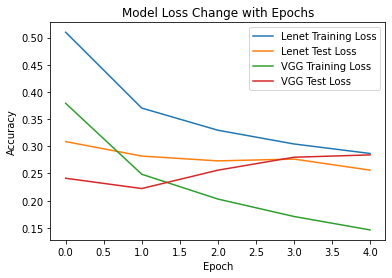

In [39]:
plt.plot(lenet_history.history['loss'])
plt.plot(lenet_history.history['val_loss'])
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model Loss Change with Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LeNet Training Loss', 'LeNet Test Loss', 'VGG Training Loss','VGG Test Loss'], loc='upper right')
plt.show()

So we can see that by training the VGG model for the same number of epochs as the LeNet model, we're actually degrading performance on the test set (high variance) by overfitting. In fact, we can conclude that we don't need such a deep neural network as the VGG and LeNet is best suited for our purpose.

<a id = 'partIII'></a>
# [Part III: Search for a Road Less Travelled](#toc)

> `Humans are creatures of habit (pun intended 😜). Machines even more so. Where we differ is while humans fail to acknowledge the naked truth (I'm on fire with puns today 🔥🔥), machines discern the most unobvious ones.`

<a id = 'tuning_path'></a>
## 5. [On hyperparameters and other Mundanities](#toc)



As per the problem statement, we will now proceed to modify the LeNet model to add:
1. Batch Normalisation
2. Dropout Regularisation
3. Reduced LR on Plateau
4. Early Stopping

It should be interesting how these changes impact our model!

<a id = 'mod_lenet'></a>
### 5.1 [Modified LeNet Model](#toc)

In [13]:
def modified_LeNet(training_images_augmented, training_labels_augmented, validation_images, validation_labels, kernel_size = 3, optimizer = "adam", dropout_prob = 0.2, monitor_quantity = 'val_loss', patience_reducelr = 2, patience_earlystopping = 4,loss = keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'], epochs = 5):
    """
    Implements a tweaked version of the LeNet neural network
    
    Arguments:-
    1) Training Image Data
    2) Training Labels
    3) Cross Validation Set Image Data
    4) Cross Validation Set Label Data
    5) Kernel Size of all Convolution layers
    6) Optimizer for learning rate
    7) Dropout Probability
    8) Quantity to monitor for reducing learning rate and early stopping condition
    9) Patience for reducing learning rate (patience is the number of epochs)
    10) Patience for early stop condition (patience is the number of epochs; set as greater than patience for reducing learning rate)
    11) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
    12) Metrics to judge model performance
    13) Number of epochs
    
    Returns:-
    Trained model implementing LeNet Neural Network with a few modifications (such as kernel size variation, batch normalisation layers, dropout regularisation layers, reduced lr on plateau, early stopping condition and activation functions)
    """
    mod_lenet_model = keras.models.Sequential([
                                            keras.layers.Conv2D(6, kernel_size=kernel_size, strides=1,  activation='relu', input_shape=training_images_augmented[0].shape, padding='same'),
                                            keras.layers.BatchNormalization(),
                                            keras.layers.MaxPool2D(),
                                            keras.layers.Conv2D(16, kernel_size=kernel_size, strides=1, activation='relu', padding='same'),
                                            keras.layers.BatchNormalization(),
                                            keras.layers.MaxPool2D(),
                                            keras.layers.Flatten(),
                                            keras.layers.Dense(120, activation='relu'),
                                            keras.layers.Dropout(dropout_prob),
                                            keras.layers.BatchNormalization(),
                                            keras.layers.Dense(84, activation='relu'),
                                            keras.layers.Dropout(dropout_prob),
                                            keras.layers.BatchNormalization(),
                                            keras.layers.Dense(10, activation='softmax')
                                            ])
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor=monitor_quantity, factor=0.2, patience=patience_reducelr, min_lr=0.001)
    early_stopping = keras.callbacks.EarlyStopping(monitor=monitor_quantity, patience = patience_earlystopping)
    
    mod_lenet_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

    history = mod_lenet_model.fit(training_images_augmented, training_labels_augmented, epochs=epochs, verbose = 1, validation_data=(validation_images, validation_labels), callbacks = [reduce_lr, early_stopping])
    return mod_lenet_model, history


We have to suitably modify the `implement_cnn` function to now accomodate the modified LeNet architecture.

<a id = 'modified_cnn'></a>
### 5.2 [A Modified CNN Function](#toc)

We will proceed to modify the CNN function to include the modified LeNet design.

In [14]:
def implement_cnn(training_images_augmented, validation_images, training_labels_augmented, validation_labels, cnn_model = "lenet", kernel_size = 3, optimizer = "adam", dropout_prob = 0.2, monitor_quantity = 'val_loss', patience_reducelr = 2, patience_earlystopping = 4,loss = keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'], epochs = 5):
    """
    Implements CNN based on choice of architecture
    Arguments:-
    1) Training Image Data
    2) Cross Validation Set Image Data
    3) Training Labels
    4) Cross Validation Set Label Data
    5) Choice of CNN architecture
    6) Kernel Size of all Convolution layers
    7) Optimizer for learning rate
    8) Dropout Probability
    9) Quantity to monitor for reducing learning rate and early stopping condition
    10) Patience for reducing learning rate (patience is the number of epochs)
    11) Patience for early stop condition (patience is the number of epochs; set as greater than patience for reducing learning rate)
    12) Loss Function (will be fixed to categorical cross entropy since output is softmax layer)
    13) Metrics to judge model performance
    14) Number of epochs
    
    Returns:-
    Trained model implementing CNN architecture as per choice
    """
    training_images_augmented = reshape_images(training_images_augmented)
    validation_images = reshape_images(validation_images)
    if cnn_model == "lenet":
        model, history = LeNet(training_images_augmented,
                      training_labels_augmented,
                      validation_images,
                      validation_labels,
                      kernel_size,
                      optimizer,
                      loss,
                      metrics,
                      epochs)
    elif cnn_model == "vgg":
        model, history = VGG(training_images_augmented,
                            training_labels_augmented,
                            validation_images,
                            validation_labels,
                            kernel_size,
                            optimizer,
                            loss,
                            metrics,
                            epochs)
    elif cnn_model == "modified_lenet":
        model, history = modified_LeNet(training_images_augmented, 
                                        training_labels_augmented,
                                        validation_images,
                                        validation_labels,
                                        kernel_size,
                                        optimizer,
                                        dropout_prob,
                                        monitor_quantity,
                                        patience_reducelr,
                                        patience_earlystopping,
                                        loss,
                                        metrics,
                                        epochs
                                       )
    return model, history

<a id = 'training_mod_lenet'></a>
### 5.3 [Training the Modified LeNet Model](#toc)

We draw closer to figuring out the perfect recipe for the data with this section! Here we'll train our modified LeNet model over the training data.

In [ ]:
mod_lenet_model, mod_lenet_history = implement_cnn(training_images_augmented,
                                            validation_images,
                                            training_labels_augmented,
                                            validation_labels,
                                            cnn_model = "modified_lenet",
                                            kernel_size = 3,
                                            optimizer = "adam",
                                            dropout_prob = 0.2,
                                            monitor_quantity = 'val_loss',
                                            patience_reducelr = 2,
                                            patience_earlystopping = 4,
                                            loss = keras.losses.sparse_categorical_crossentropy,
                                            metrics = ['accuracy'],
                                            epochs = 5)

Epoch 1/5
13125/13125 [==============================] - 119s 8ms/step - loss: 0.6245 - accuracy: 0.7737 - val_loss: 0.3163 - val_accuracy: 0.8841
Epoch 2/5
13125/13125 [==============================] - 98s 7ms/step - loss: 0.4764 - accuracy: 0.8270 - val_loss: 0.2994 - val_accuracy: 0.8911
Epoch 3/5
13125/13125 [==============================] - 98s 7ms/step - loss: 0.4385 - accuracy: 0.8407 - val_loss: 0.2733 - val_accuracy: 0.8989
Epoch 4/5
13125/13125 [==============================] - 98s 7ms/step - loss: 0.4151 - accuracy: 0.8482 - val_loss: 0.2791 - val_accuracy: 0.8966
Epoch 5/5
 5732/13125 [============>.................] - ETA: 54s - loss: 0.4023 - accuracy: 0.8524- ETA: 5

In [56]:
evaluate_model(mod_lenet_model, test_images_reduced, test_labels_reduced)

Evaluate on test data
94/94 [==============================] - 0s 3ms/step - loss: 0.2553 - accuracy: 0.9100
Test loss: 0.25533169507980347
Test accuracy: 0.9100000262260437


[0.25533169507980347, 0.9100000262260437]

<a id = 'plotting_lenet_and_mod_lenet'></a>
### 5.4 [Comparison of LeNet and Modified LeNet](#toc)

In this section, we'll compare the loss functions of the two models over the epochs they are trained over. This should be insightful as to how these models are converging.

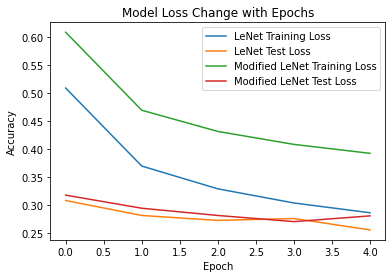

In [57]:
plt.plot(lenet_history.history['loss'])
plt.plot(lenet_history.history['val_loss'])
plt.plot(mod_lenet_history.history['loss'])
plt.plot(mod_lenet_history.history['val_loss'])
plt.title('Model Loss Change with Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LeNet Training Loss', 'LeNet Test Loss', 'Modified LeNet Training Loss','Modified LeNet Test Loss'], loc='upper right')
plt.show()

So while it appears that the modified LeNet model performed marginally better than the LeNet model, the difference could well be attributable to the initialization of weights rather than an inherent superiority of the model design. However, it is worth noting that the modified LeNet design has begun overfitting which indicates that it may have converged to the minima faster than the LeNet architecture. 
Moreover, the modified LeNet design itself is more robust and has mechanisms for self correction preventing overfitting, divergence from minimum and an early exit condition which would help the designer have a better handle over the training process. 